In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


# Load and Prepare Data

In [3]:
# Define data path
data_dir = '/content/drive/MyDrive/Applied ML/Data/Assignment 5/Image Classification'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = ImageFolder(data_dir, transform=transform)

# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Define the Model

In [4]:
# Load a pre-trained model
model = models.resnet18(pretrained=True)

# Freeze all layers in the model
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # '2' for binary classification

# Move model to the appropriate device
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Define Loss Function and Optimizer

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


# Train the Model

In [6]:
# Training and validation loss lists
train_losses = []
val_losses = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
print(classification_report(all_labels, all_preds, target_names=['Duck', 'Chicken']))


Epoch 1, Train Loss: 0.5854, Validation Loss: 0.4321
Epoch 2, Train Loss: 0.4197, Validation Loss: 0.3319
Epoch 3, Train Loss: 0.3234, Validation Loss: 0.3031
Epoch 4, Train Loss: 0.2992, Validation Loss: 0.2649
Epoch 5, Train Loss: 0.2360, Validation Loss: 0.2502
Epoch 6, Train Loss: 0.2117, Validation Loss: 0.2334
Epoch 7, Train Loss: 0.1931, Validation Loss: 0.2325
Epoch 8, Train Loss: 0.1655, Validation Loss: 0.2157
Epoch 9, Train Loss: 0.1494, Validation Loss: 0.2105
Epoch 10, Train Loss: 0.1434, Validation Loss: 0.2195
Epoch 11, Train Loss: 0.1364, Validation Loss: 0.2075
Epoch 12, Train Loss: 0.1393, Validation Loss: 0.1983
Epoch 13, Train Loss: 0.1336, Validation Loss: 0.1971
Epoch 14, Train Loss: 0.1289, Validation Loss: 0.2235
Epoch 15, Train Loss: 0.1133, Validation Loss: 0.1982
Epoch 16, Train Loss: 0.1181, Validation Loss: 0.1894
Epoch 17, Train Loss: 0.1075, Validation Loss: 0.1913
Epoch 18, Train Loss: 0.1212, Validation Loss: 0.2104
Epoch 19, Train Loss: 0.1034, Validat

# Plotting the loss

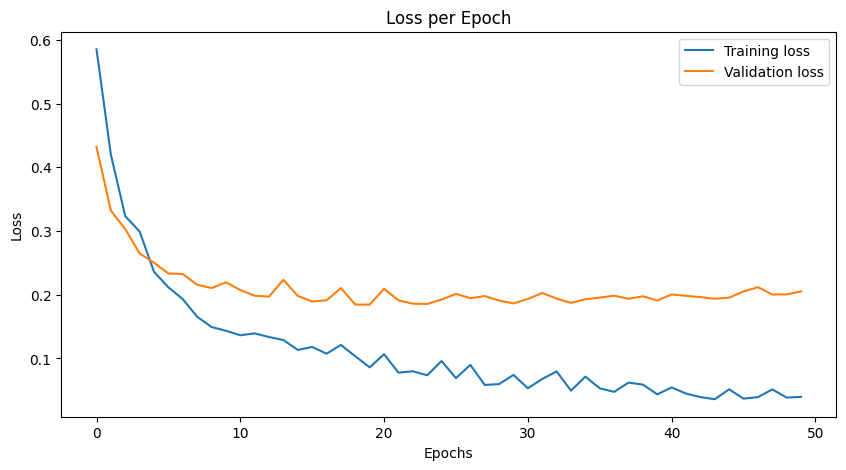

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
